In [2]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind, levene, shapiro
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, confusion_matrix
from imblearn.over_sampling import SMOTE
from scipy.stats import kstest, norm
from scipy.stats import t, f

unique_seed = 15548753


random.seed(unique_seed)  # For Python's random module
np.random.seed(unique_seed)  # For NumPy's random module


# Load the dataset
file_path = 'final1_dataset.csv'
data = pd.read_csv(file_path)

# Ensure column names are properly trimmed
data.columns = data.columns.str.strip()

**Q1) Activists have asserted that there is a strong gender bias in student evaluations of professors, with male professors enjoying a boost in rating from this bias. While this has been celebrated by ideologues, skeptics have pointed out that this research is of technically poor quality, either due to a low sample size –as small as n = 1 (Mitchell & Martin, 2018), failure to control for confounders such as teaching experience (Centra & Gaubatz, 2000) or obvious p-hacking (MacNell et al., 2015). We would like you to answer the question whether there is evidence of a pro-male gender bias in this dataset. Hint: A significance test is probably required.**

41940
22210
19730
41940
KS Statistic for male: 0.141854680285317
P-value for male: 0.0
The data does not follow a normal distribution.
KS Statistic for female: 0.1435064418317873
P-value for female: 0.0
The data does not follow a normal distribution..
Mann-Whitney U Statistic: 217366070.0
P-value: 0.1572648588302158
No statistically significant difference found between male and female ratings.


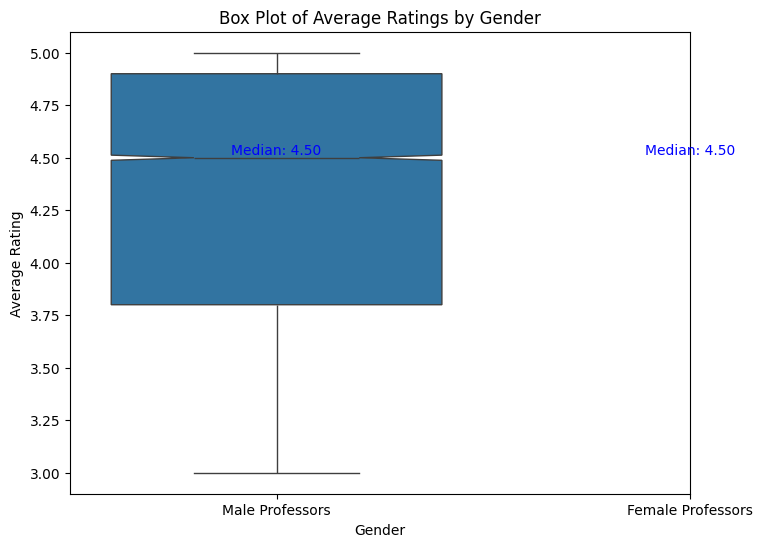

In [3]:
# Clean data - keep rows that only have 1 in either male or female column, remove rows that have 1 in both columns
cleaned_data = data[ (data["Male gender"] == 1) | (data["Female gender"] == 1)]

cleaned_data = cleaned_data[~((cleaned_data["Male gender"] == 1) & (cleaned_data["Female gender"] == 1))]
print(len(cleaned_data))

#Creating a subset for male professors
male_subset = cleaned_data[cleaned_data["Male gender"] == 1]

# Creating a subset for female professors
female_subset = cleaned_data[cleaned_data["Female gender"] == 1]

print(len(male_subset))
print(len(female_subset))
print(len(male_subset+female_subset))

# Performing KS Test to figure out if the data(male_subset, female_subset) is normal
# H0: Null Hypothesis - The data is not normally distributed
# H1: Alternate Hypothesis - the data is normally distributed

#Getting the column 'Average Ratings' for male professors into data_male
data_male = male_subset["Average Rating"]

standardized_data = (data_male - data_male.mean()) / data_male.std()

#KS test
ks_stat, p_value = kstest(standardized_data, 'norm')
print(f"KS Statistic for male: {ks_stat}")
print(f"P-value for male: {p_value}")


if p_value < 0.005:
    print("The data does not follow a normal distribution.")
else:
    print("The data follows a normal distribution.")

#Getting the column 'Average Ratings' for female professors into data_female

data_female = female_subset["Average Rating"]


standardized_data = (data_female - data_female.mean()) / data_female.std()

#KS test
ks_stat, p_value = kstest(standardized_data, 'norm')


print(f"KS Statistic for female: {ks_stat}")
print(f"P-value for female: {p_value}")


if p_value < 0.005:
    print("The data does not follow a normal distribution..")
else:
    print("The data follows a normal distribution..")

#Since the data does nnot follow a normal distribution use Mann Whitney U test
# Mann-Whitney U Test
stat, p_value = mannwhitneyu(data_male, data_female, alternative='two-sided')


print(f"Mann-Whitney U Statistic: {stat}")
print(f"P-value: {p_value}")

# Interpret results
alpha = 0.005  # significance level
if p_value < alpha:
    print("There is a statistically significant difference between male and female ratings.")
else:
    print("No statistically significant difference found between male and female ratings.")

%matplotlib inline

# Create the box plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=[data_male, data_female], notch=True)

male_median = data_male.median()
female_median = data_female.median()
# Add median annotations
plt.text(0, male_median, f"Median: {male_median:.2f}", ha="center", va="bottom", fontsize=10, color="blue")
plt.text(1, female_median, f"Median: {female_median:.2f}", ha="center", va="bottom", fontsize=10, color="blue")

# Set labels
plt.xticks([0, 1], ["Male Professors", "Female Professors"])
plt.title("Box Plot of Average Ratings by Gender")
plt.ylabel("Average Rating")
plt.xlabel("Gender")
plt.show()



**Q2) Is there a gender difference in the spread (variance/dispersion) of the ratings distribution? Again, it is advisable to consider the statistical significance of any observed gender differences in this spread.**

0.39128324227515926
0.40361294527157815
0.6255263721660017
0.6353053952797647
Levene's test statistic: 7.313644838864062
P-value: 0.006846059275689574
No statistically significant difference between ratings distribution.


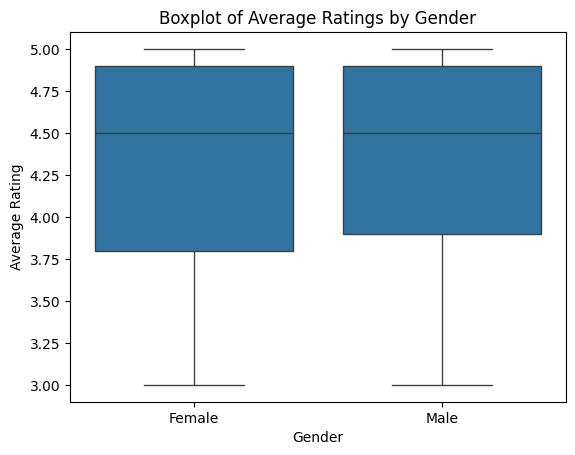

In [ ]:
# Using Levene's Test to compare the standard deviation and variances between two data (male and female ratings distribution)
# calculating the standard deviation and variances
male_variance = data_male.var()
female_variance = data_female.var()

print(male_variance)
print(female_variance)


# Calculate standard deviation for each group
male_std = data_male.std()
female_std = data_female.std()

print(male_std)
print(female_std)

# Perform Levene's test for equality of variances
stat, p_value = levene(data_male, data_female)

print("Levene's test statistic:", stat)
print("P-value:", p_value)

if p_value < 0.005:
    print("There is a statistically significant difference ratings distribution.")
else:
    print("No statistically significant difference between ratings distribution.")

#print(data.head)

data['Gender'] = cleaned_data.apply(
    lambda row: 'Male' if row['Male gender'] == 1 else 'Female',
    axis=1
)

data = data.dropna(subset=['Gender', 'Average Rating'])

sns.boxplot(x='Gender', y='Average Rating', data=data)
plt.title('Boxplot of Average Ratings by Gender')
plt.show()


**Q3) What is the likely size of both of these effects (gender bias in average rating, gender bias in spread of average rating), as estimated from this dataset? Please use 95% confidence and make sure to report each/both.**

Mean difference: -0.00
95% Confidence interval for the mean difference: (-0.01, 0.01)
Cohen's d (effect size): -0.00
Variance ratio (F-ratio): 0.97
95% Confidence interval for the variance ratio: (0.93, 1.01)


<ipython-input-23-b1f33508ba54>:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=ratings_df, x='Gender', y='Rating', palette='Set2')


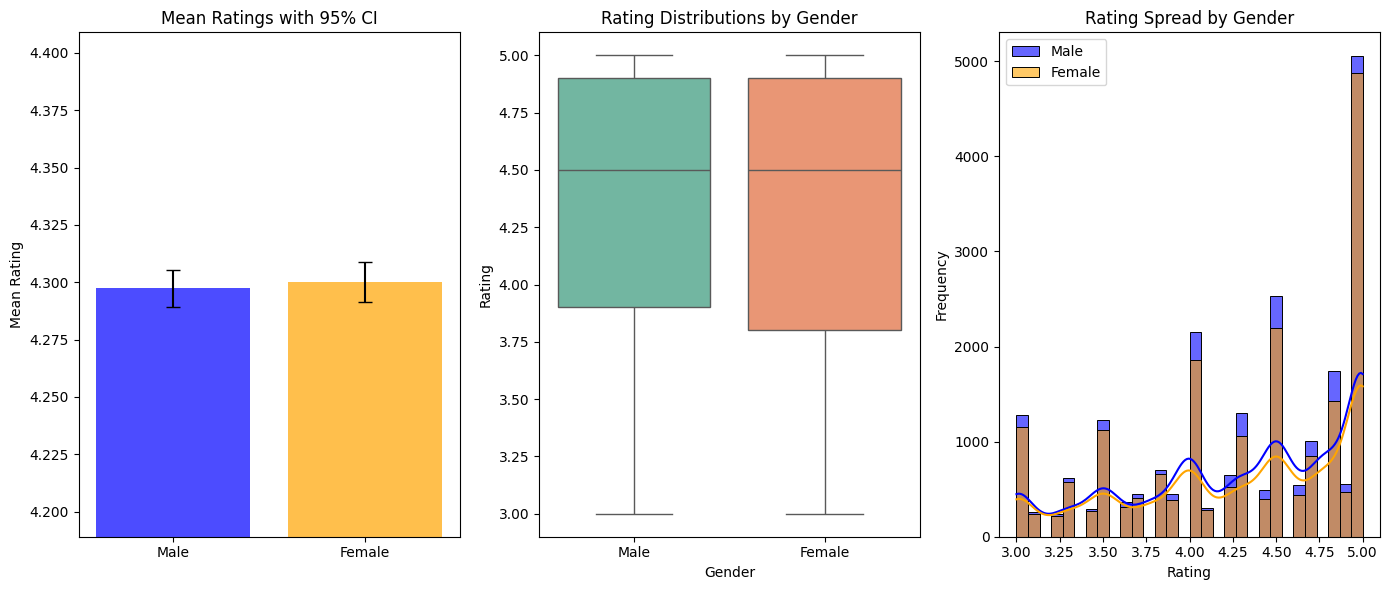

In [ ]:
# Mean difference
mean_male = data_male.mean()
mean_female = data_female.mean()
mean_diff = mean_male - mean_female


# Standard errors and margin of error
n_male, n_female = len(data_male), len(data_female)
se_diff = np.sqrt(data_male.var(ddof=1) / n_male + data_female.var(ddof=1) / n_female)
margin_of_error = t.ppf(0.975, df=min(n_male, n_female) - 1) * se_diff

# Confidence interval
ci_lower, ci_upper = mean_diff - margin_of_error, mean_diff + margin_of_error

# Pooled standard deviation and Cohen's d
pooled_std = np.sqrt((data_male.var(ddof=1) + data_female.var(ddof=1)) / 2)
cohens_d = mean_diff / pooled_std

print(f"Mean difference: {mean_diff:.2f}")
print(f"95% Confidence interval for the mean difference: ({ci_lower:.2f}, {ci_upper:.2f})")
print(f"Cohen's d (effect size): {cohens_d:.2f}")

# Variance ratio
var_ratio = data_male.var(ddof=1) / data_female.var(ddof=1)

# Confidence interval for the variance ratio
alpha = 0.005
df1, df2 = n_male - 1, n_female - 1
ci_var_lower = var_ratio / f.ppf(1 - alpha / 2, df1, df2)
ci_var_upper = var_ratio * f.ppf(1 - alpha / 2, df1, df2)

print(f"Variance ratio (F-ratio): {var_ratio:.2f}")
print(f"95% Confidence interval for the variance ratio: ({ci_var_lower:.2f}, {ci_var_upper:.2f})")


# Create a combined DataFrame for visualization
ratings_df = pd.DataFrame({
    'Rating': np.concatenate([data_male, data_female]),
    'Gender': ['Male'] * len(data_male) + ['Female'] * len(data_female)
})

# Calculate means and confidence intervals for bar plot
male_mean, female_mean = data_male.mean(), data_female.mean()
male_se = data_male.std(ddof=1) / np.sqrt(len(data_male))
female_se = data_female.std(ddof=1) / np.sqrt(len(data_female))
male_ci = [male_mean - 1.96 * male_se, male_mean + 1.96 * male_se]
female_ci = [female_mean - 1.96 * female_se, female_mean + 1.96 * female_se]

# Bar plot with confidence intervals
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plt.bar(['Male', 'Female'], [male_mean, female_mean], yerr=[male_se * 1.96, female_se * 1.96],
        capsize=5, color=['blue', 'orange'], alpha=0.7)
plt.title('Mean Ratings with 95% CI')
plt.ylabel('Mean Rating')
plt.ylim([min(male_ci[0], female_ci[0]) - 0.1, max(male_ci[1], female_ci[1]) + 0.1])

# Boxplot
plt.subplot(1, 3, 2)
sns.boxplot(data=ratings_df, x='Gender', y='Rating', palette='Set2')
plt.title('Rating Distributions by Gender')
plt.ylabel('Rating')
plt.xlabel('Gender')

# Histogram
plt.subplot(1, 3, 3)
sns.histplot(data_male, bins=30, color='blue', label='Male', kde=True, alpha=0.6)
sns.histplot(data_female, bins=30, color='orange', label='Female', kde=True, alpha=0.6)
plt.title('Rating Spread by Gender')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

**Q4) Is there a gender difference in the tags awarded by students? Make sure to teach each of the 20 tags for a potential gender difference and report which of them exhibit a statistically significant different. Comment on the 3 most gendered (lowest p-value) and least gendered (highest p-value) tags.**

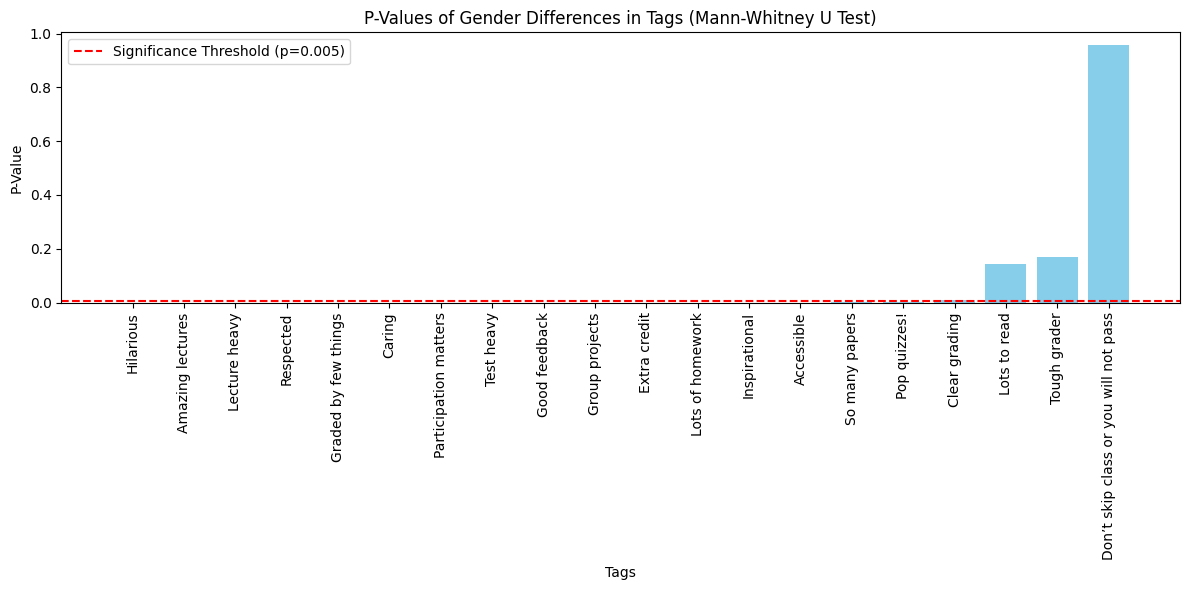

### Most Gendered Tags ###
                 Tag  U-Statistic        P-Value
12         Hilarious  252748638.0  4.772169e-240
15  Amazing lectures  235904806.0   2.139594e-61
19     Lecture heavy  231397819.0   1.465936e-43

### Least Gendered Tags ###
                                     Tag  U-Statistic   P-Value
3                           Lots to read  217626558.0  0.142315
0                           Tough grader  220483116.0  0.170477
5  Don’t skip class or you will not pass  219158534.0  0.956647


In [ ]:
# List of tags
tag_columns = [
    "Tough grader", "Good feedback", "Respected", "Lots to read",
    "Participation matters", "Don’t skip class or you will not pass",
    "Lots of homework", "Inspirational", "Pop quizzes!", "Accessible",
    "So many papers", "Clear grading", "Hilarious", "Test heavy",
    "Graded by few things", "Amazing lectures", "Caring", "Extra credit",
    "Group projects", "Lecture heavy"
]

# Separate male and female data
male_data_ = data[data["Male gender"] == 1]
female_data_ = data[data["Female gender"] == 1]

# Conduct Mann-Whitney U test for each tag
results = []
for tag in tag_columns:
    u_stat, p_value = mannwhitneyu(male_data_[tag], female_data_[tag], alternative='two-sided')
    results.append({"Tag": tag, "U-Statistic": u_stat, "P-Value": p_value})

# Create results DataFrame and sort by p-value
results_df_ = pd.DataFrame(results).sort_values(by="P-Value")

# Visualization of P-Values
plt.figure(figsize=(12, 6))
plt.bar(results_df_['Tag'], results_df_['P-Value'], color='skyblue')
plt.axhline(0.005, color='red', linestyle='--', label='Significance Threshold (p=0.005)')
plt.xticks(rotation=90)
plt.title('P-Values of Gender Differences in Tags (Mann-Whitney U Test)')
plt.xlabel('Tags')
plt.ylabel('P-Value')
plt.legend()
plt.tight_layout()
plt.show()

# Highlight the 3 most and least gendered tags
mostgendered = results_df_.head(3)
leastgendered = results_df_.tail(3)

print("### Most Gendered Tags ###")
print(mostgendered)

print("\n### Least Gendered Tags ###")
print(leastgendered)


**Q5) Is there a gender difference in terms of average difficulty? Again, a significance test is indicate**

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 22210.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 19730.
  res = hypotest_fun_out(*samples, **kwds)
<ipython-input-25-fbad1b184453>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


### Results Summary ###
{'Male Group Normality (p-value)': 6.06616094321346e-51, 'Female Group Normality (p-value)': 3.7092657170302633e-50, "Equal Variance Test (Levene's p-value)": 0.2803995062675546, 'T-Statistic': 2.847947268321216, 'P-Value': 0.004402385011191216}


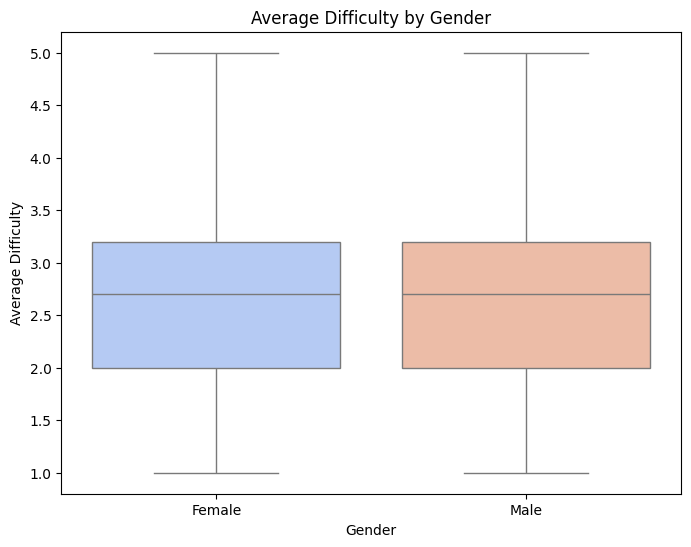

<ipython-input-25-fbad1b184453>:42: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(male_difficulty_, shade=True, label="Male", color="red")
<ipython-input-25-fbad1b184453>:43: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(female_difficulty_, shade=True, label="Female", color="purple")


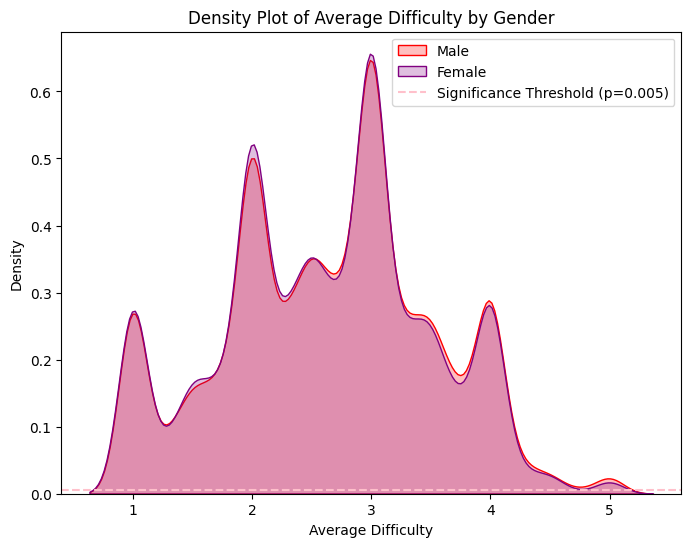

In [ ]:
male_difficulty_ = data[data["Male gender"] == 1]["Average Difficulty"]
female_difficulty_ = data[data["Female gender"] == 1]["Average Difficulty"]

# Statistical Tests
# 1. Check normality for both groups
male_normality_ = shapiro(male_difficulty_)
female_normality_ = shapiro(female_difficulty_)

# 2. Check equality of variances using Levene's test
equal_variance_test = levene(male_difficulty_, female_difficulty_)

# 3. Perform t-test (Welch's t-test if variances are unequal)
t_stats, p_value = ttest_ind(male_difficulty_, female_difficulty_, equal_var=False)

# Results summary
results_summary = {
    "Male Group Normality (p-value)": male_normality_.pvalue,
    "Female Group Normality (p-value)": female_normality_.pvalue,
    "Equal Variance Test (Levene's p-value)": equal_variance_test.pvalue,
    "T-Statistic": t_stats,
    "P-Value": p_value
}

print("### Results Summary ###")
print(results_summary)

# Visualization
# Create a boxplot for visual comparison
plt.figure(figsize=(8, 6))
sns.boxplot(
    x=data["Male gender"].replace({1: "Male", 0: "Female"}),
    y=data["Average Difficulty"],
    palette="coolwarm"
)
plt.title('Average Difficulty by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Difficulty')
plt.show()

# Create a density plot for distributions
plt.figure(figsize=(8, 6))
sns.kdeplot(male_difficulty_, shade=True, label="Male", color="red")
sns.kdeplot(female_difficulty_, shade=True, label="Female", color="purple")
plt.axhline(0.005, color='pink', linestyle='--', label='Significance Threshold (p=0.005)')
plt.title('Density Plot of Average Difficulty by Gender')
plt.xlabel('Average Difficulty')
plt.ylabel('Density')
plt.legend()
plt.show()


**Q6) Please quantify the likely size of this effect at 95% confidence**

### Results Summary ###
{'Male Mean': 2.6396126613910873, 'Female Mean': 2.61644681839294, 'Mean Difference': 0.02316584299814739, 'Standard Error of Difference': 0.008319058128489744, '95% Confidence Interval': (0.006860489066307492, 0.03947119692998729), 'T-Statistic': 2.7846713702856087, 'P-Value': 0.005360433122499844}


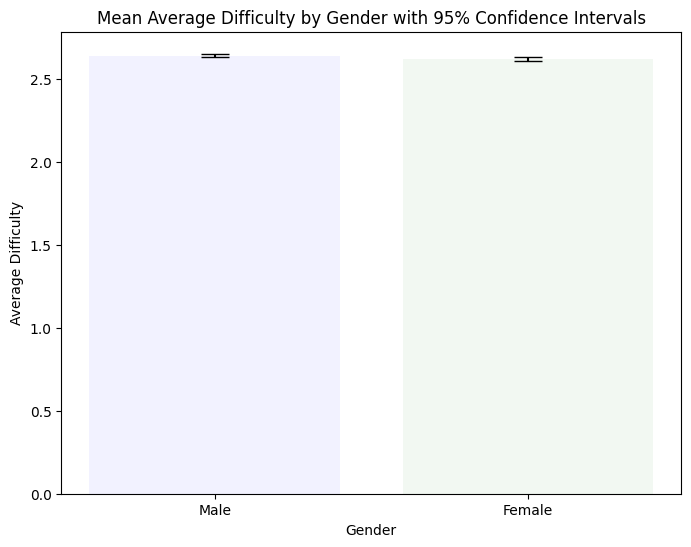

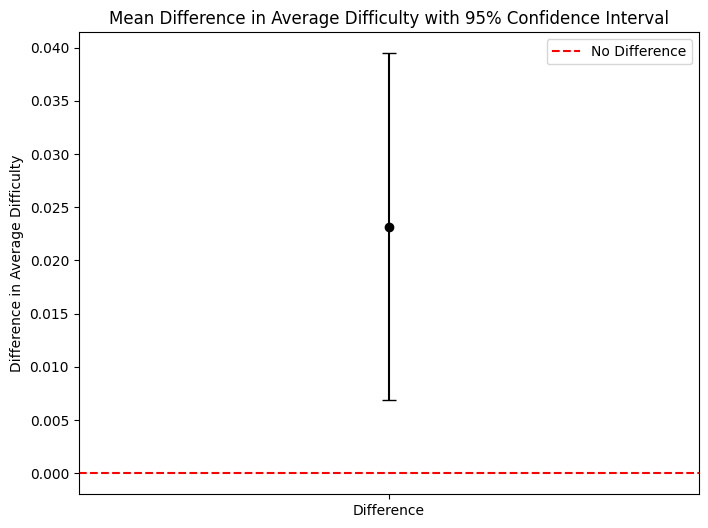

In [ ]:
# Separate "Average Difficulty" by gender
male_difficulty_ = data[data["Male gender"] == 1]["Average Difficulty"]
female_difficulty_ = data[data["Female gender"] == 1]["Average Difficulty"]

# Statistical Tests
# 1. Check normality for both groups
male_normality = shapiro(male_difficulty_)
female_normality = shapiro(female_difficulty_)

# 2. Check equality of variances using Levene's test
equal_variance_test = levene(male_difficulty_, female_difficulty_)

# 3. Perform t-test (Welch's t-test if variances are unequal)
t_stats, p_value = ttest_ind(male_difficulty_, female_difficulty_, equal_var=False)

# 4. Calculate Confidence Interval for the Difference in Means
mean_of_male = male_difficulty_.mean()
mean_of_female = female_difficulty_.mean()
mean_diff = mean_of_male - mean_of_female

std_of_male = male_difficulty_.std()
std_of_female = female_difficulty_.std()
male_n = len(male_difficulty_)
female_n = len(female_difficulty_)

# Standard error of the difference
se_diff = np.sqrt((std_of_male**2 / male_n) + (std_of_female**2 / female_n))

# Calculate 95% confidence interval
confidence_interval = (mean_diff - 1.96 * se_diff, mean_diff + 1.96 * se_diff)

# Results summary
results_summary = {
    "Male Mean": mean_of_male,
    "Female Mean": mean_of_female,
    "Mean Difference": mean_diff,
    "Standard Error of Difference": se_diff,
    "95% Confidence Interval": confidence_interval,
    "T-Statistic": t_stats,
    "P-Value": p_value,
}

print("### Results Summary ###")
print(results_summary)

# Visualization 1: Confidence Interval Bar Plot
plt.figure(figsize=(8, 6))
plt.bar(["Male", "Female"], [mean_of_male, mean_of_female], yerr=[1.96 * std_of_male / np.sqrt(male_n), 1.96 * std_of_female / np.sqrt(female_n)],
        color=["blue", "green"], alpha=0.05, capsize=10)
plt.title("Mean Average Difficulty by Gender with 95% Confidence Intervals")
plt.ylabel("Average Difficulty")
plt.xlabel("Gender")
plt.show()

# Visualization 2: Difference with Confidence Interval
plt.figure(figsize=(8, 6))
plt.errorbar(x=["Difference"], y=[mean_diff], yerr=[1.96 * se_diff], fmt='o', color='black', capsize=5)
plt.axhline(0, color='red', linestyle='--', label='No Difference')
plt.title("Mean Difference in Average Difficulty with 95% Confidence Interval")
plt.ylabel("Difference in Average Difficulty")
plt.legend()
plt.show()



7. Build a regression model predicting average rating from all numerical predictors (the ones in the rmpCapstoneNum.csv) file. Make sure to include the R^2 and RMSE of this model. Which of these factors is most strongly predictive of average rating? Hint: Make sure to address collinearity concerns.

In [4]:
# Select numerical columns
numerical_columns = [
    'Average Difficulty', 'Number of ratings', 'Received a pepper?',
    'Proportion retaking class', 'Online ratings', 'Male gender', 'Female gender',
    'Tough grader', 'Good feedback', 'Respected', 'Lots to read', 'Participation matters',
    'Don’t skip class or you will not pass', 'Lots of homework', 'Inspirational',
    'Pop quizzes!', 'Accessible', 'So many papers', 'Clear grading', 'Hilarious',
    'Test heavy', 'Graded by few things', 'Amazing lectures', 'Caring',
    'Extra credit', 'Group projects', 'Lecture heavy'
]
X = data[numerical_columns]
y = data['Average Rating']

# Handle missing values (replace NaN in proportions with 0 if logical)
X = X.fillna(0)
y = y.fillna(y.mean())  # Replace missing target values with the mean

# Address multicollinearity using VIF
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data['feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Iteratively remove predictors with high VIF
vif_threshold = 5  # Common threshold
while True:
    vif = calculate_vif(X)
    if vif['VIF'].max() > vif_threshold:
        X = X.drop(columns=[vif.loc[vif['VIF'].idxmax(), 'feature']])
    else:
        break

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=unique_seed)

# Train the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Identify the most predictive factor
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Output results
print(f"R^2: {r2}")
print(f"RMSE: {rmse}")
print("Most strongly predictive factor:")
print(coefficients.iloc[0])


R^2: 0.2256298988195602
RMSE: 0.5586194309283845
Most strongly predictive factor:
Feature        Received a pepper?
Coefficient              0.200235
Name: 1, dtype: object


<Figure size 1000x600 with 0 Axes>

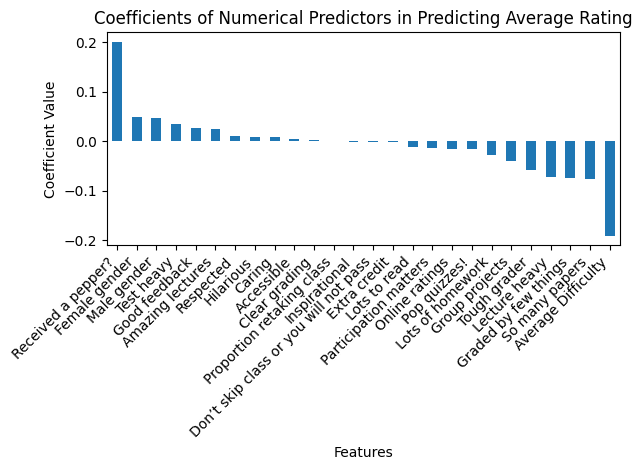

In [5]:
# Visualization: Coefficients of Numerical Predictors
plt.figure(figsize=(10, 6))
coefficients.sort_values(by='Coefficient', ascending=False).plot.bar(x='Feature', y='Coefficient', legend=False)
plt.title('Coefficients of Numerical Predictors in Predicting Average Rating')
plt.ylabel('Coefficient Value')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

8. Build a regression model predicting average ratings from all tags (the ones in the rmpCapstoneTags.csv) file. Make sure to include the R^2 and RMSE of this model. Which of these tags is most strongly predictive of average rating? Hint: Make sure to address collinearity concerns. Also comment on how this model compares to the previous one

In [3]:
# Select only tag-related columns
tags_columns = [
    'Tough grader', 'Good feedback', 'Respected', 'Lots to read', 'Participation matters',
    'Don’t skip class or you will not pass', 'Lots of homework', 'Inspirational',
    'Pop quizzes!', 'Accessible', 'So many papers', 'Clear grading', 'Hilarious',
    'Test heavy', 'Graded by few things', 'Amazing lectures', 'Caring',
    'Extra credit', 'Group projects', 'Lecture heavy'
]
X = data[tags_columns]
y = data['Average Rating']

# Handle missing values (replace NaN in tags with 0 if logical)
X = X.fillna(0)
y = y.fillna(y.mean())  # Replace missing target values with the mean

# Address multicollinearity using VIF
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data['feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Iteratively remove predictors with high VIF
vif_threshold = 5  # Common threshold
while True:
    vif = calculate_vif(X)
    if vif['VIF'].max() > vif_threshold:
        X = X.drop(columns=[vif.loc[vif['VIF'].idxmax(), 'feature']])
    else:
        break

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = unique_seed)

# Train the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Identify the most predictive factor
coefficients = pd.DataFrame({
    'Tag': X.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Output results
print(f"R^2: {r2}")
print(f"RMSE: {rmse}")
print("Most strongly predictive tag:")
print(coefficients.iloc[0])

R^2: 0.10933745965046071
RMSE: 0.5990986534232912
Most strongly predictive tag:
Tag            Tough grader
Coefficient       -0.089363
Name: 0, dtype: object


<Figure size 1200x600 with 0 Axes>

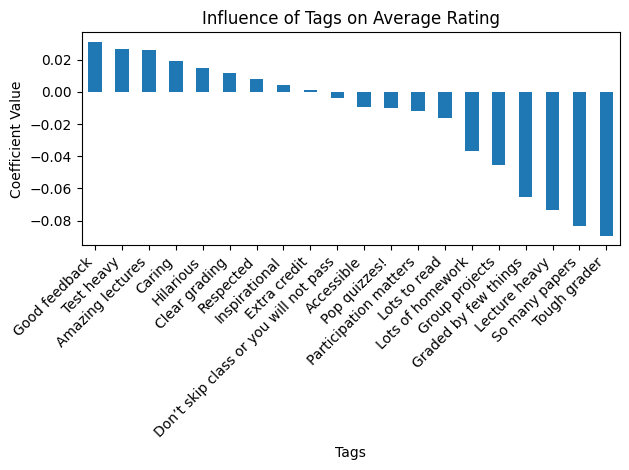

In [7]:

# Bar plot of coefficients
plt.figure(figsize=(12, 6))
coefficients.sort_values(by='Coefficient', ascending=False).plot.bar(x='Tag', y='Coefficient', legend=False)
plt.title('Influence of Tags on Average Rating')
plt.ylabel('Coefficient Value')
plt.xlabel('Tags')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


9. Build a regression model predicting average difficulty from all tags (the ones in the rmpCapstoneTags.csv) file. Make sure to include the R^2 and RMSE of this model. Which of these tags is most strongly predictive of average difficulty? Hint: Make sure to address collinearity concern

In [5]:
# Select only tag-related columns
tags_columns = [
    'Tough grader', 'Good feedback', 'Respected', 'Lots to read', 'Participation matters',
    'Don’t skip class or you will not pass', 'Lots of homework', 'Inspirational',
    'Pop quizzes!', 'Accessible', 'So many papers', 'Clear grading', 'Hilarious',
    'Test heavy', 'Graded by few things', 'Amazing lectures', 'Caring',
    'Extra credit', 'Group projects', 'Lecture heavy'
]
X = data[tags_columns]
y = data['Average Difficulty']

# Handle missing values (replace NaN in tags with 0 if logical)
X = X.fillna(0)
y = y.fillna(y.mean())  # Replace missing target values with the mean

# Address multicollinearity using VIF
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data['feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Iteratively remove predictors with high VIF
vif_threshold = 5  # Common threshold
while True:
    vif = calculate_vif(X)
    if vif['VIF'].max() > vif_threshold:
        X = X.drop(columns=[vif.loc[vif['VIF'].idxmax(), 'feature']])
    else:
        break

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=unique_seed)

# Train the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Identify the most predictive factor
coefficients = pd.DataFrame({
    'Tag': X.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Output results
print(f"R^2: {r2}")
print(f"RMSE: {rmse}")
print("Most strongly predictive tag:")
print(coefficients.iloc[0])

# Optional: Save the coefficients for reference
coefficients.to_csv('difficulty_tag_regression_coefficients.csv', index=False)


R^2: 0.06984266777624548
RMSE: 0.8447389769672373
Most strongly predictive tag:
Tag            Tough grader
Coefficient        0.150771
Name: 0, dtype: object


<Figure size 1200x600 with 0 Axes>

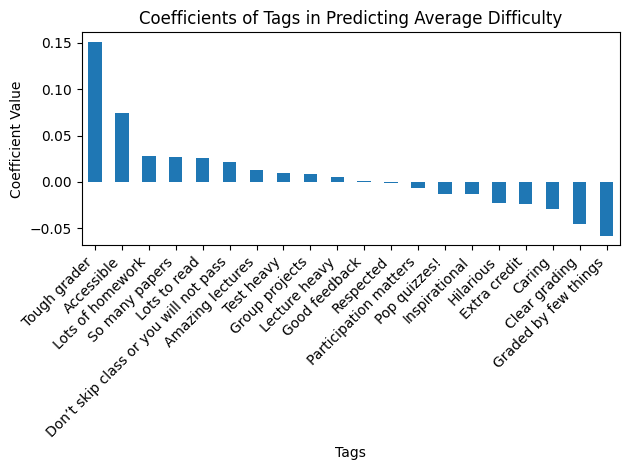

In [6]:
plt.figure(figsize=(12, 6))
coefficients.sort_values(by='Coefficient', ascending=False).plot.bar(x='Tag', y='Coefficient', legend=False)
plt.title('Coefficients of Tags in Predicting Average Difficulty')
plt.ylabel('Coefficient Value')
plt.xlabel('Tags')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Q10) Build a classification model that predicts whether a professor receives a “pepper” from all available factors(both tags and numerical). Make sure to include model quality metrics such as AU(RO)C and also address class imbalance concerns.**

### Model Quality Metrics ###
AUROC: 0.7546016458737707

Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.82      0.79      7325
         1.0       0.60      0.53      0.56      3784

    accuracy                           0.72     11109
   macro avg       0.69      0.67      0.68     11109
weighted avg       0.71      0.72      0.72     11109



<ipython-input-40-a46daa515bd6>:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importances.head(10), palette="viridis")


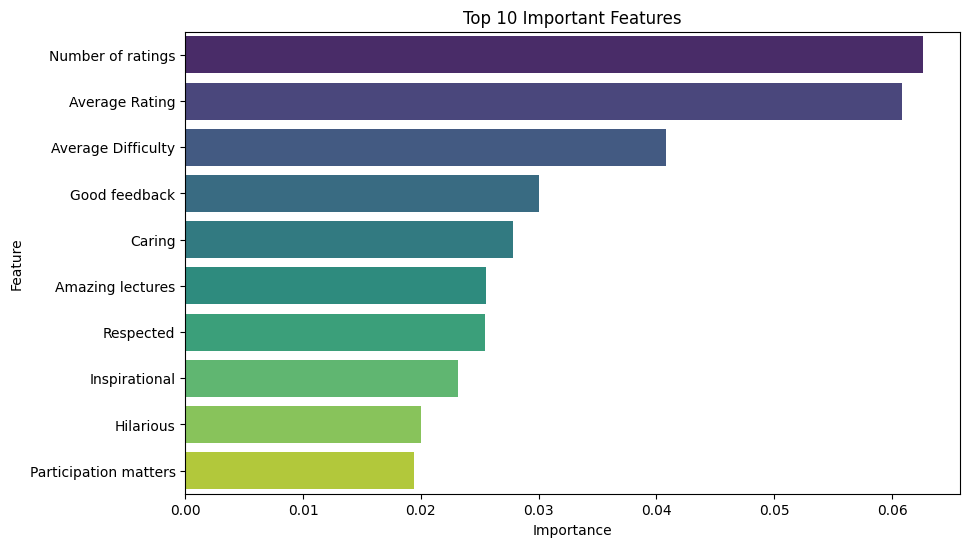

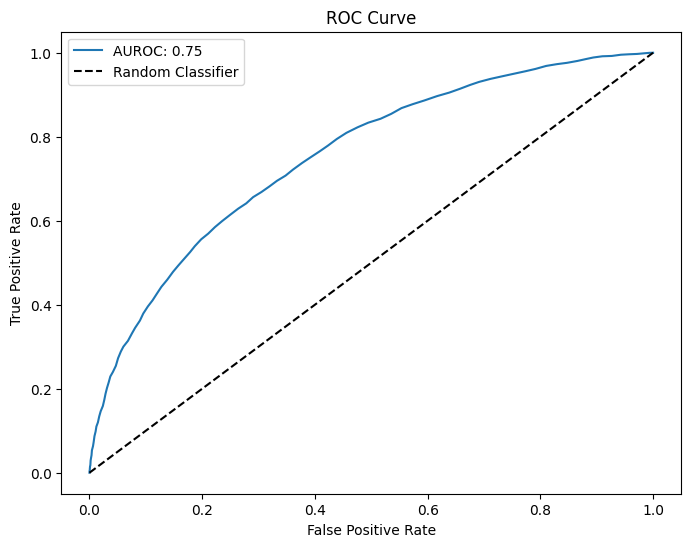

In [ ]:
# Features and target variable
X = data.drop(columns=["Received a pepper?", "Male gender", "Female gender"])  # Exclude target and redundant features
y = data["Received a pepper?"]

# Separate numerical and categorical columns
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = X.select_dtypes(include=["object"]).columns

# Impute missing values
X[numerical_cols] = X[numerical_cols].fillna(X[numerical_cols].median())
X[categorical_cols] = X[categorical_cols].fillna("Missing")

# Encode categorical columns using one-hot encoding
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=unique_seed, stratify=y)

# Address class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train_balanced, y_train_balanced)

# Predictions
y_prediction = model.predict(X_test)
y_probability = model.predict_proba(X_test)[:, 1]

# Model Evaluation
roc_auc = roc_auc_score(y_test, y_probability)
classification_rep = classification_report(y_test, y_prediction)
conf_matrix = confusion_matrix(y_test, y_prediction)

print("### Model Quality Metrics ###")
print(f"AUROC: {roc_auc}")
print("\nClassification Report:")
print(classification_rep)

# Feature Importance
feature_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Visualization: Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importances.head(10), palette="viridis")
plt.title("Top 10 Important Features")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probability)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUROC: {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


**Q EXTRA CREDIT) Tell us something interesting about this dataset that is not trivial and not already part of an answer (implied or explicitly) to these enumerated questions[Suggestion: Do something with the qualitative data, e.g. major, university or state by linking thequalitative data to thetwo other data files(tags and numerical)].**

### Unique Average Ratings in the Dataset ###
                     Major/Field  Average Rating
0               Criminal Justice             5.0
1                        English             3.2
2                        English             3.6
3                        English             3.5
4                        English             3.0
...                          ...             ...
55418                  Animation             3.0
55437      Apparel Merchandising             3.2
55442  Food  Beverage Management             4.5
55456             Bioengineering             4.3
55478      Radiological Sciences             5.0

[5565 rows x 2 columns]

Overall Average Rating Across All Majors: 4.28

### Grouped Data (Qualitative Analysis) ###
                   Major/Field  average_rating  average_difficulty  \
0                         Acad        4.500000            1.000000   
1          Academic Advisement        4.550000            1.166667   
2         Academic Development        

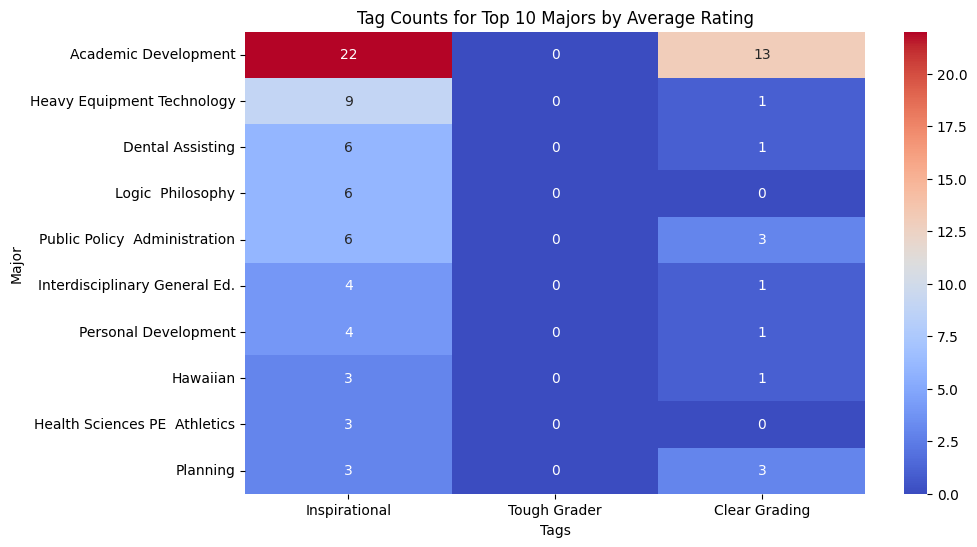

<ipython-input-36-a8d2893197a8>:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="average_rating", y="Major/Field", data=top_majors, palette="viridis")


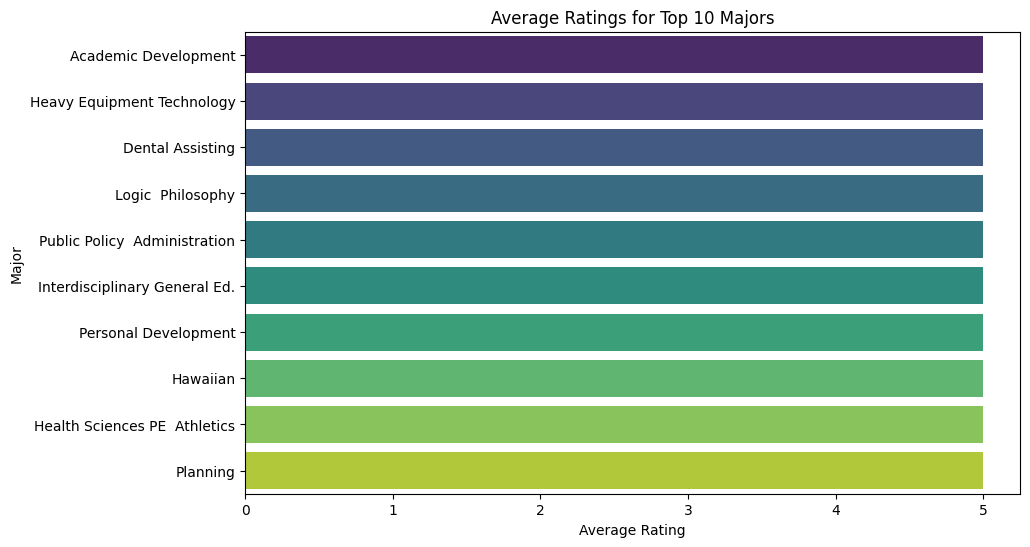

<ipython-input-36-a8d2893197a8>:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="average_difficulty", y="Major/Field", data=top_majors, palette="coolwarm")


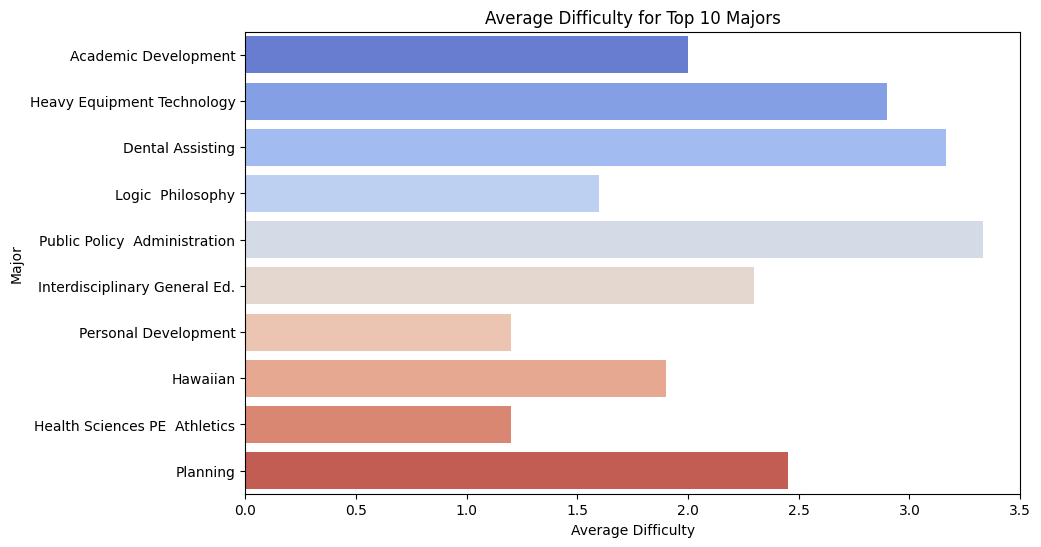

In [ ]:
# Check for duplicates or uniform values in Average Rating
print("### Unique Average Ratings in the Dataset ###")
print(data[["Major/Field", "Average Rating"]].drop_duplicates())

# Calculate the overall average rating for all majors
overall_average_rating = data["Average Rating"].mean()
print(f"\nOverall Average Rating Across All Majors: {overall_average_rating:.2f}")

# Group data by "Major/Field" and compute aggregate statistics
qualitative_analysis = data.groupby("Major/Field", as_index=False).agg(
    average_rating=("Average Rating", "mean"),
    average_difficulty=("Average Difficulty", "mean"),
    inspirational_tags=("Inspirational", "sum"),
    tough_grader_tags=("Tough grader", "sum"),
    clear_grading_tags=("Clear grading", "sum")
)

# Check the grouped data
print("\n### Grouped Data (Qualitative Analysis) ###")
print(qualitative_analysis)

# Sort by average rating and inspirational tags
qualitative_analysis = qualitative_analysis.sort_values(
    by=["average_rating", "inspirational_tags"], ascending=[False, False]
)

# Select top 10 majors for visualization
top_majors = qualitative_analysis.head(10)

# Verify the top majors have distinct average ratings
print("\n### Top 10 Majors with Distinct Average Ratings ###")
print(top_majors)

# Visualization: Heatmap of Tag Counts by Top Majors
plt.figure(figsize=(10, 6))
sns.heatmap(
    top_majors[["inspirational_tags", "tough_grader_tags", "clear_grading_tags"]],
    annot=True,
    fmt="d",
    cmap="coolwarm",
    xticklabels=["Inspirational", "Tough Grader", "Clear Grading"],
    yticklabels=top_majors["Major/Field"].values
)
plt.title("Tag Counts for Top 10 Majors by Average Rating")
plt.xlabel("Tags")
plt.ylabel("Major")
plt.show()

# Bar plot for average rating for top majors
plt.figure(figsize=(10, 6))
sns.barplot(x="average_rating", y="Major/Field", data=top_majors, palette="viridis")
plt.title("Average Ratings for Top 10 Majors")
plt.xlabel("Average Rating")
plt.ylabel("Major")
plt.show()

# Bar plot for average difficulty for top majors
plt.figure(figsize=(10, 6))
sns.barplot(x="average_difficulty", y="Major/Field", data=top_majors, palette="coolwarm")
plt.title("Average Difficulty for Top 10 Majors")
plt.xlabel("Average Difficulty")
plt.ylabel("Major")
plt.show()
